In [2]:
# main imports
import os
import sys
import ast
import glob
import math
import shutil
import random
import importlib
import subprocess

from itertools import product

import numpy as np
import pandas as pd
import seaborn as sns

from scipy import stats

import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.pylab as pylab
import upsetplot
import seaborn as sns

plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.size'] = 24
%matplotlib inline

pd.set_option('display.max_columns', None)

In [3]:
%load_ext autoreload
%autoreload 1

sys.path.insert(0, "/ccb/salz8-1/avaraby/orfanage/soft")
%aimport definitions

In [6]:
# paths

base_dir = "/ccb/salz8-1/avaraby/orfanage/"

orfanage_bin = base_dir+"bin/orfanage"
gffcompare_bin = "/ccb/salz7-data/sw2/bin/gffcompare"
gffread_bin = "/ccb/salz7-data/sw2/bin/gffread"
igvtools_bin = "/ccb/salz7-data/sw/bin/igvtools"
sashimi_bin = base_dir+"bin/sashimi.py"

fa_fname = base_dir+"data/hg38.fa"
gtf_fname = base_dir+"data/gencode.v41.gtf"
mane_gtf_fname = base_dir+"data/MANE.v10.gtf"

gencode_outdir = base_dir+"gencode/"
refseq_outdir = base_dir+"refseq/"
figdir = base_dir+"figures/"

In [7]:
# arguments
num_threads = 30

In [8]:
gdf = pd.read_csv(gencode_outdir+"df.tsv",sep="\t")
rdf = pd.read_csv(refseq_outdir+"df.tsv",sep="\t")
display(rdf.head())

tmp1 = gdf[["ilpd_def"]].reset_index(drop=True)
tmp1["db"] = "GENCODE"
tmp2 = rdf[["ilpd_def"]].reset_index(drop=True)
tmp2["db"] = "RefSeq"
cdf = pd.concat([tmp1,tmp2],axis=0)
cdf["all"] = "x"

,tid,has_cds_orf,seqid,strand,coords,chain_orf,has_cds_def,chain_def,mane_tid,chain_mane,mod_chain_orf,c1len_orf,c2len_orf,match_start_orf,match_end_orf,num_bp_extra_orf,num_bp_missing_orf,num_bp_inframe_orf,num_bp_match_orf,num_bp_outframe_orf,lpd_orf,ilpd_orf,mlpd_orf,mod_chain_def,c1len_def,c2len_def,match_start_def,match_end_def,num_bp_extra_def,num_bp_missing_def,num_bp_inframe_def,num_bp_match_def,num_bp_outframe_def,lpd_def,ilpd_def,mlpd_def
0,rna-XM_005244720.5,1,chr1,+,chr1:1308597-1310853,"[[1308644, 1308720], [1308915, 1308972], [1309...",1,"[[1308644, 1308720], [1308915, 1308972], [1309...",rna-NM_153339.3,"[[1308644, 1308720], [1308915, 1308972], [1309...","[[1308644, 1308720, 0], [1308915, 1308972, 0],...",687,912,True,False,13,238,473,674,201,75,51,73,"[[1308644, 1308720, 0], [1308915, 1308972, 0],...",687,912,True,False,13,238,473,674,201,75,51,73
1,rna-XM_047444716.1,1,chr1,+,chr1:1308597-1311016,"[[1308644, 1308720], [1308915, 1308972], [1309...",1,"[[1308644, 1308720], [1308915, 1308972], [1309...",rna-NM_153339.3,"[[1308644, 1308720], [1308915, 1308972], [1309...","[[1308644, 1308720, 0], [1308915, 1308972, 0],...",729,912,True,False,17,200,699,712,13,79,76,78,"[[1308644, 1308720, 0], [1308915, 1308972, 0],...",729,912,True,False,17,200,699,712,13,79,76,78
2,rna-XM_047444722.1,1,chr1,+,chr1:1308597-1311071,"[[1308644, 1308720], [1308915, 1308972], [1309...",1,"[[1308644, 1308720], [1308915, 1308972], [1309...",rna-NM_153339.3,"[[1308644, 1308720], [1308915, 1308972], [1309...","[[1308644, 1308720, 0], [1308915, 1308972, 0],...",687,912,True,False,0,225,473,687,214,75,51,75,"[[1308644, 1308720, 0], [1308915, 1308972, 0],...",687,912,True,False,0,225,473,687,214,75,51,75
3,rna-NM_001346116.2,1,chr1,+,chr1:1308597-1311677,"[[1308644, 1308720], [1308915, 1308972], [1309...",1,"[[1308644, 1308720], [1308915, 1308972], [1309...",rna-NM_153339.3,"[[1308644, 1308720], [1308915, 1308972], [1309...","[[1308644, 1308720, 0], [1308915, 1308972, 0],...",981,912,True,True,69,0,912,912,0,107,100,100,"[[1308644, 1308720, 0], [1308915, 1308972, 0],...",981,912,True,True,69,0,912,912,0,107,100,100
4,rna-NM_153339.3,1,chr1,+,chr1:1308597-1311677,"[[1308644, 1308720], [1308915, 1308972], [1309...",1,"[[1308644, 1308720], [1308915, 1308972], [1309...",rna-NM_153339.3,"[[1308644, 1308720], [1308915, 1308972], [1309...","[[1308644, 1308720, 0], [1308915, 1308972, 0],...",912,912,True,True,0,0,912,912,0,100,100,100,"[[1308644, 1308720, 0], [1308915, 1308972, 0],...",912,912,True,True,0,0,912,912,0,100,100,100


In [9]:
# how many non orfs are not the same?
print("percent of transcripts in RefSeq with the same chain as mane: "+str((len(rdf[rdf["chain_mane"]==rdf["chain_def"]])/len(rdf))*100))
print("percent of transcripts in RefSeq with the difference chain as mane: "+str((len(rdf[~(rdf["chain_mane"]==rdf["chain_def"])&\
                                                                                          (rdf["has_cds_def"]==1)])/len(rdf))*100))
print("percent of transcripts in RefSeq with no ORF: "+str((len(rdf[(rdf["has_cds_def"]==0)])/len(rdf))*100))

print("percent of transcripts in GENCODE with the same chain as mane: "+str((len(gdf[gdf["chain_mane"]==gdf["chain_def"]])/len(gdf))*100))
print("percent of transcripts in GENCODE with the difference chain as mane: "+str((len(gdf[~(gdf["chain_mane"]==gdf["chain_def"])&\
                                                                                           (gdf["has_cds_def"]==1)])/len(gdf))*100))
print("percent of transcripts in GENCODE with no ORF: "+str((len(gdf[(gdf["has_cds_def"]==0)])/len(gdf))*100))

percent of transcripts in RefSeq with the same chain as mane: 27.291553053193212
percent of transcripts in RefSeq with the difference chain as mane: 64.67861511931257
percent of transcripts in RefSeq with no ORF: 8.029831827494215
percent of transcripts in GENCODE with the same chain as mane: 20.505744976069096
percent of transcripts in GENCODE with the difference chain as mane: 36.365620566546625
percent of transcripts in GENCODE with no ORF: 43.12863445738428


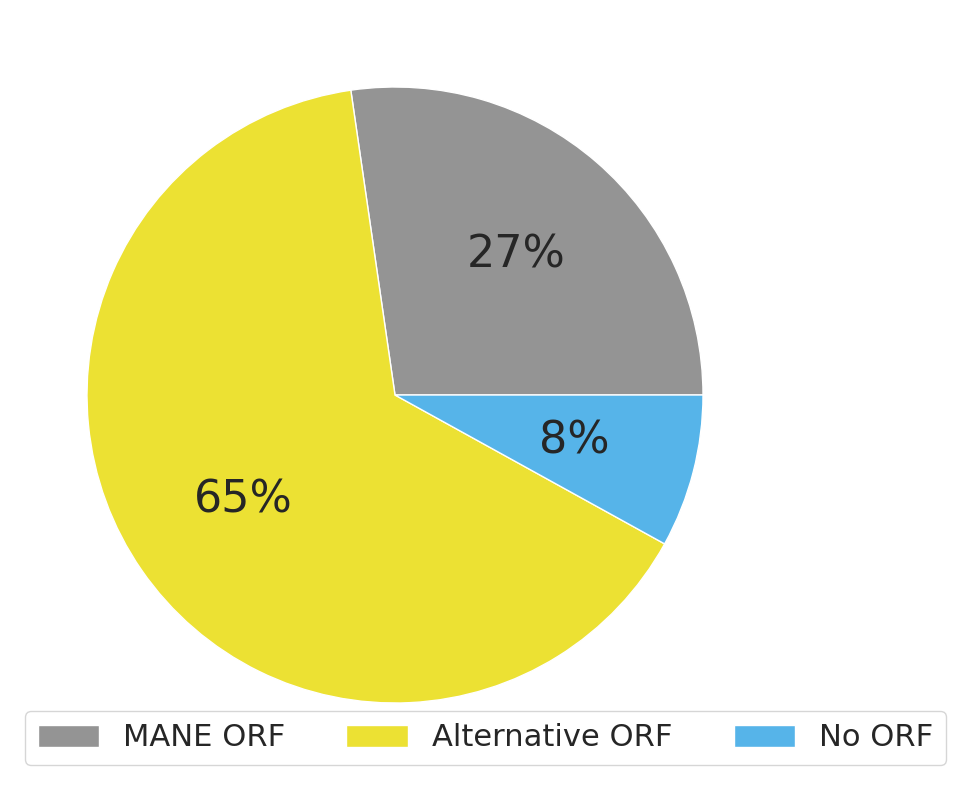

In [10]:
params = {'figure.figsize': (10,10),
          'legend.fontsize': 22,
          'axes.labelsize': 32,
          'axes.titlesize': 22,
          'xtick.labelsize': 22,
          'ytick.labelsize': 22,
          'font.size': 32}
pylab.rcParams.update(params)

sns.set_style("white")

data = [(len(rdf[rdf["chain_mane"]==rdf["chain_def"]])/len(rdf))*100,
        (len(rdf[~(rdf["chain_mane"]==rdf["chain_def"])&(rdf["has_cds_def"]==1)])/len(rdf))*100,
        (len(rdf[(rdf["has_cds_def"]==0)])/len(rdf))*100]
labels = ["MANE ORF",
          "Alternative ORF",
          "No ORF"]
plt.pie(data, autopct='%.0f%%',colors=sns.color_palette("colorblind")[7:])
# plt.legend(labels, loc="right",bbox_to_anchor=(1.5, 0.5))
plt.legend(labels, loc="lower left", ncol=3)
plt.savefig(figdir+"refseq_orfs.svg")
plt.show()

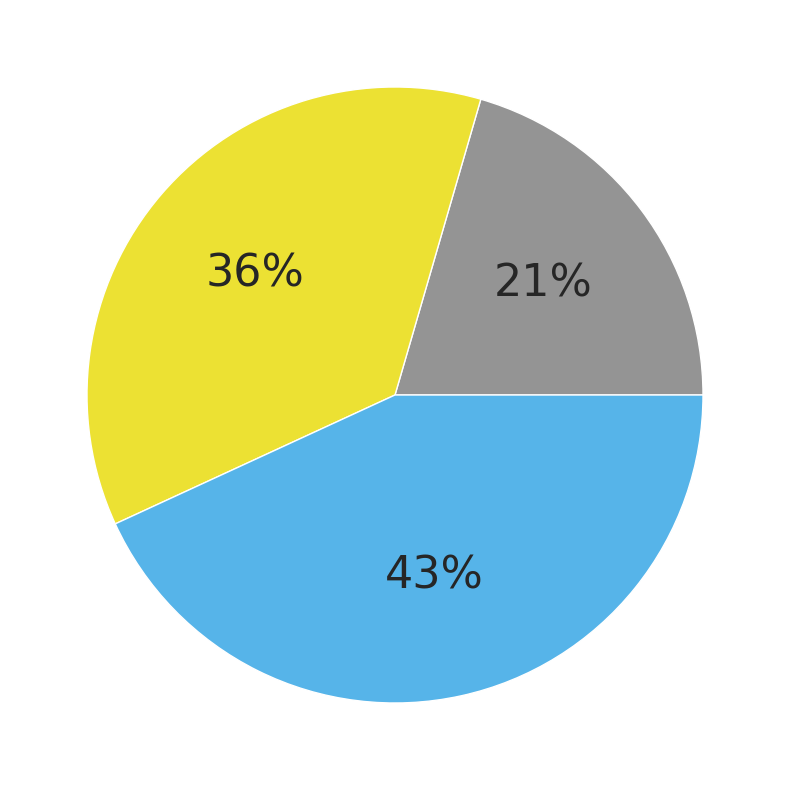

In [11]:
data = [(len(gdf[gdf["chain_mane"]==gdf["chain_def"]])/len(gdf))*100,
        (len(gdf[~(gdf["chain_mane"]==gdf["chain_def"])&(gdf["has_cds_def"]==1)])/len(gdf))*100,
        (len(gdf[(gdf["has_cds_def"]==0)])/len(gdf))*100]
labels = ["MANE ORF",
          "Alternative ORF",
          "No ORF"]
plt.pie(data, autopct='%.0f%%',colors=sns.color_palette("colorblind")[7:])
plt.savefig(figdir+"gencode_orfs.svg")
plt.show()

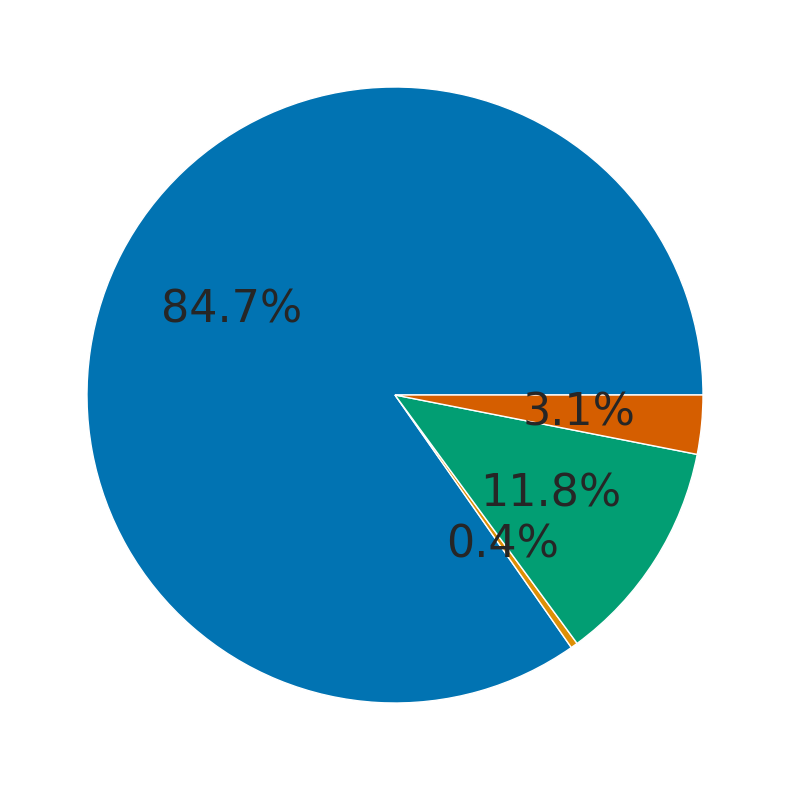

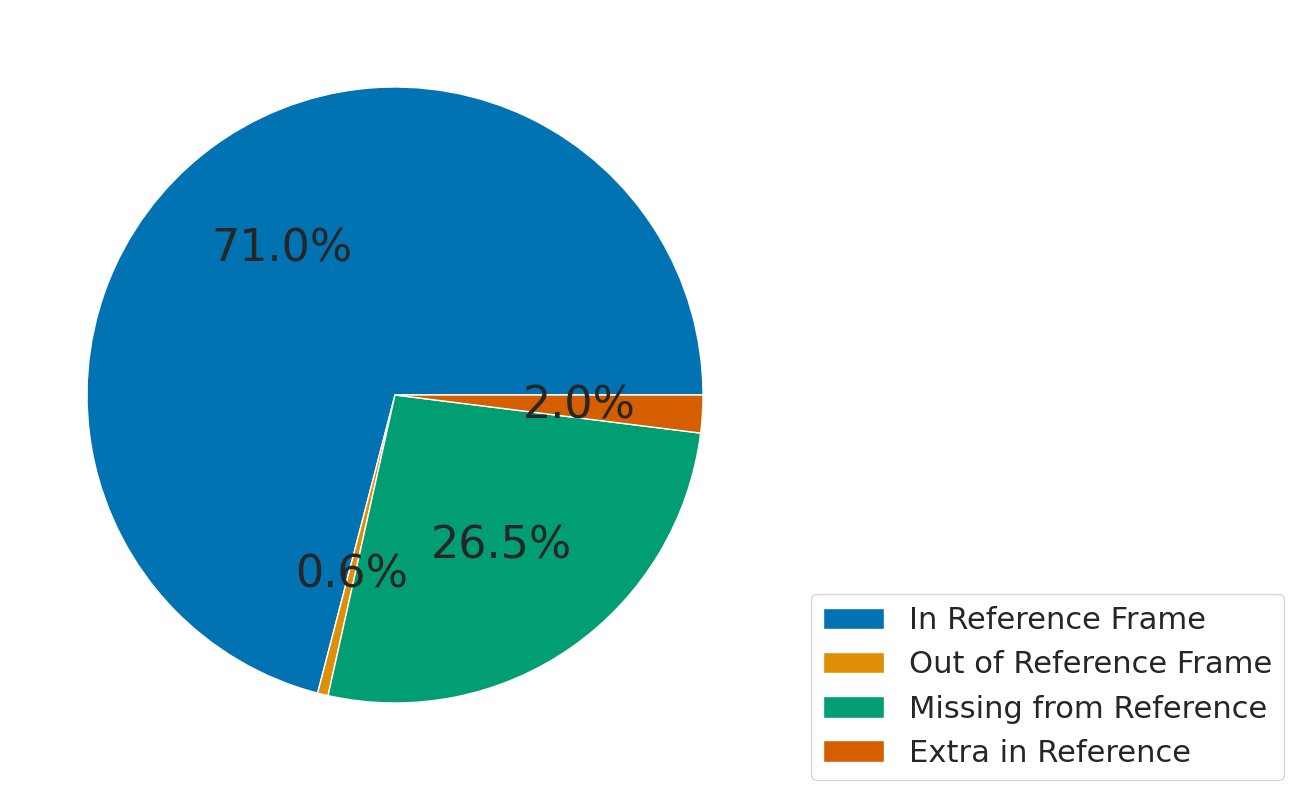

In [13]:
total_inframe = rdf["num_bp_inframe_def"].sum()
total_outframe = rdf["num_bp_outframe_def"].sum()
total_missing = rdf["num_bp_missing_def"].sum()
total_extra = rdf["num_bp_extra_def"].sum()

total_all = total_inframe+total_outframe+total_missing+total_extra


data = [(total_inframe/total_all)*100,
        (total_outframe/total_all)*100,
        (total_missing/total_all)*100,
        (total_extra/total_all)*100]
labels = ["In Reference Frame",
          "Out of Reference Frame",
          "Missing from Reference",
          "Extra in Reference"]
plt.pie(data, autopct='%.1f%%',colors=sns.color_palette("colorblind"))
plt.show()

total_inframe = gdf["num_bp_inframe_def"].sum()
total_outframe = gdf["num_bp_outframe_def"].sum()
total_missing = gdf["num_bp_missing_def"].sum()
total_extra = gdf["num_bp_extra_def"].sum()

total_all = total_inframe+total_outframe+total_missing+total_extra


data = [(total_inframe/total_all)*100,
        (total_outframe/total_all)*100,
        (total_missing/total_all)*100,
        (total_extra/total_all)*100]
labels = ["In Reference Frame",
          "Out of Reference Frame",
          "Missing from Reference",
          "Extra in Reference"]

p = plt.pie(data, autopct='%.1f%%',colors=sns.color_palette("colorblind"))
plt.legend(labels, loc=(1.04, 0))
plt.show()

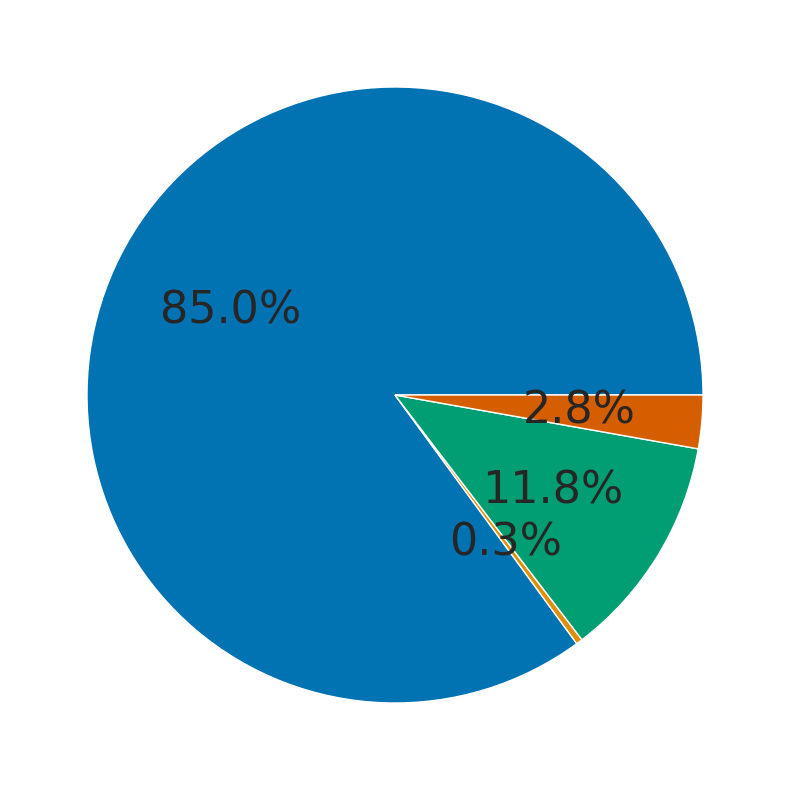

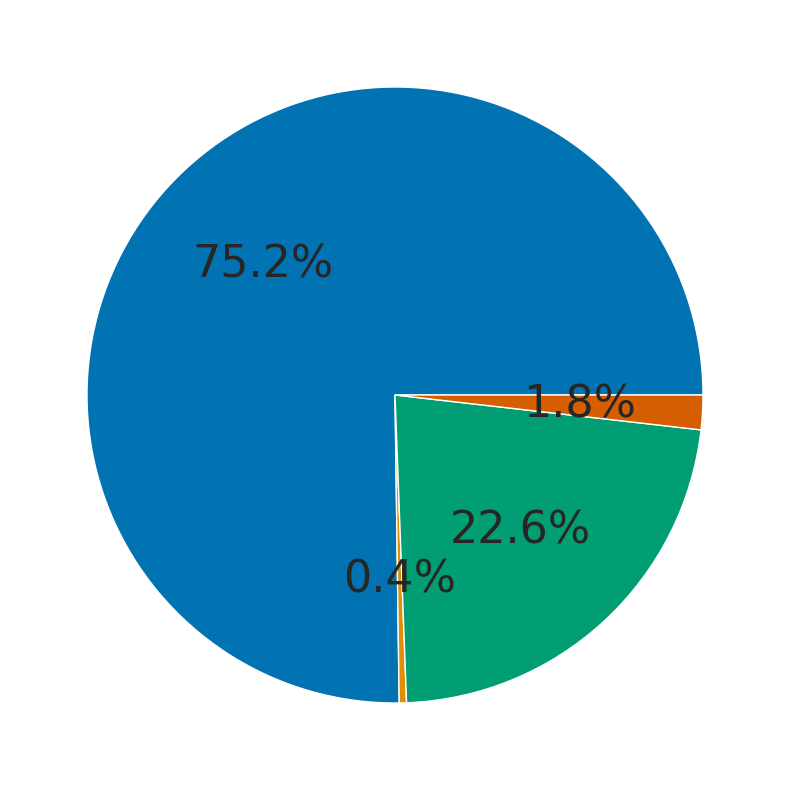

In [14]:
# compare to orfanage
total_inframe = rdf[rdf["has_cds_def"]==1]["num_bp_inframe_orf"].sum()
total_outframe = rdf[rdf["has_cds_def"]==1]["num_bp_outframe_orf"].sum()
total_missing = rdf[rdf["has_cds_def"]==1]["num_bp_missing_orf"].sum()
total_extra = rdf[rdf["has_cds_def"]==1]["num_bp_extra_orf"].sum()

total_all = total_inframe+total_outframe+total_missing+total_extra


data = [(total_inframe/total_all)*100,
        (total_outframe/total_all)*100,
        (total_missing/total_all)*100,
        (total_extra/total_all)*100]
labels = ["In Reference Frame",
          "Out of Reference Frame",
          "Missing from Reference",
          "Extra in Reference"]
plt.pie(data, autopct='%.1f%%',colors=sns.color_palette("colorblind"))
plt.show()

total_inframe = gdf[gdf["has_cds_def"]==1]["num_bp_inframe_orf"].sum()
total_outframe = gdf[gdf["has_cds_def"]==1]["num_bp_outframe_orf"].sum()
total_missing = gdf[gdf["has_cds_def"]==1]["num_bp_missing_orf"].sum()
total_extra = gdf[gdf["has_cds_def"]==1]["num_bp_extra_orf"].sum()

total_all = total_inframe+total_outframe+total_missing+total_extra


data = [(total_inframe/total_all)*100,
        (total_outframe/total_all)*100,
        (total_missing/total_all)*100,
        (total_extra/total_all)*100]
labels = ["In Reference Frame",
          "Out of Reference Frame",
          "Missing from Reference",
          "Extra in Reference"]
plt.pie(data, autopct='%.1f%%',colors=sns.color_palette("colorblind"))
plt.show()

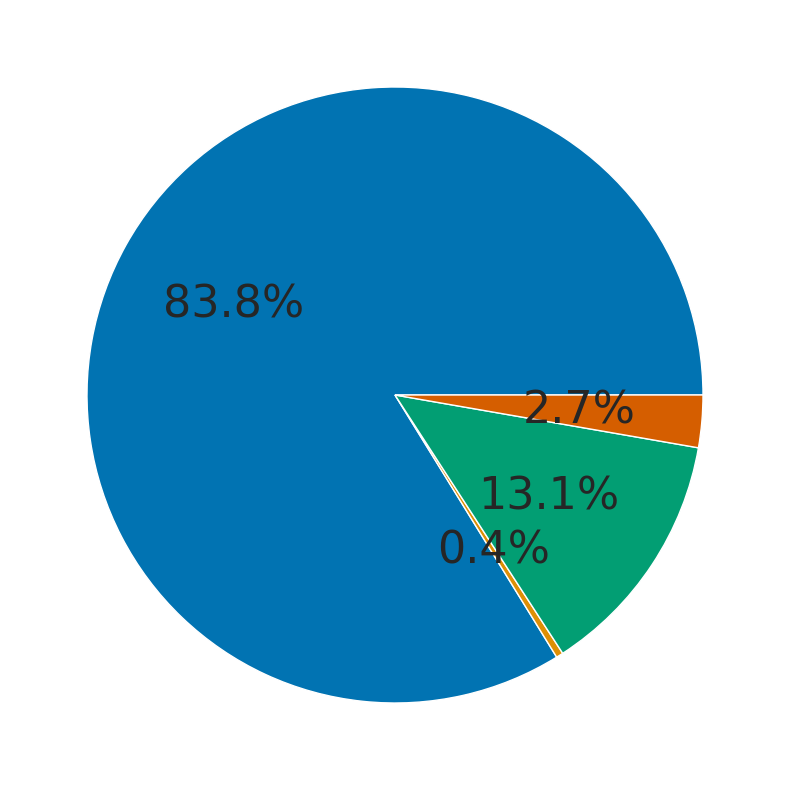

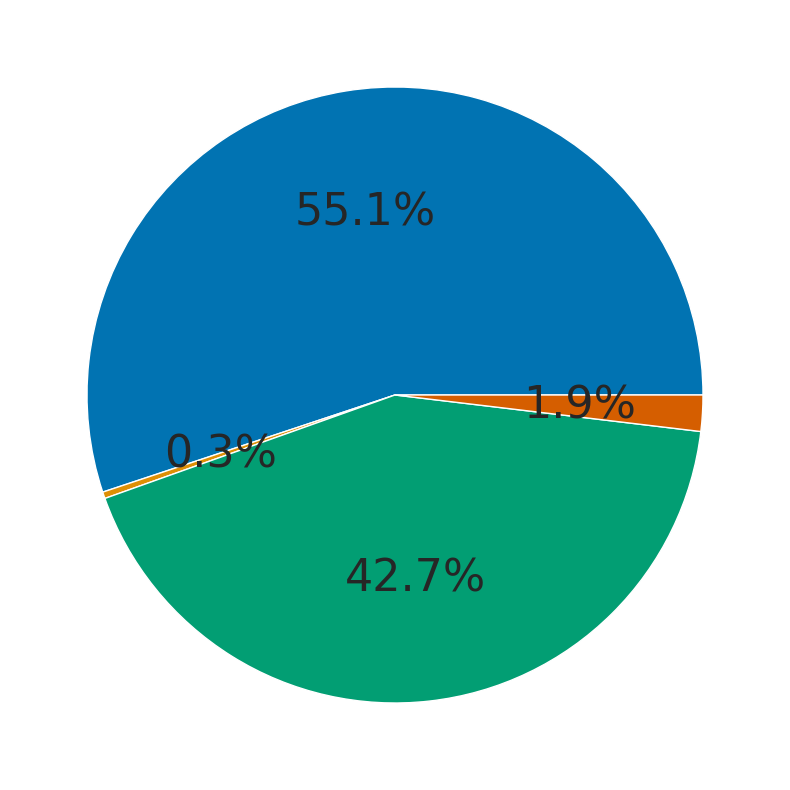

In [15]:
# compare to orfanage
total_inframe = rdf["num_bp_inframe_orf"].sum()
total_outframe = rdf["num_bp_outframe_orf"].sum()
total_missing = rdf["num_bp_missing_orf"].sum()
total_extra = rdf["num_bp_extra_orf"].sum()

total_all = total_inframe+total_outframe+total_missing+total_extra


data = [(total_inframe/total_all)*100,
        (total_outframe/total_all)*100,
        (total_missing/total_all)*100,
        (total_extra/total_all)*100]
labels = ["In Reference Frame",
          "Out of Reference Frame",
          "Missing from Reference",
          "Extra in Reference"]
plt.pie(data, autopct='%.1f%%',colors=sns.color_palette("colorblind"))
plt.show()

total_inframe = gdf["num_bp_inframe_orf"].sum()
total_outframe = gdf["num_bp_outframe_orf"].sum()
total_missing = gdf["num_bp_missing_orf"].sum()
total_extra = gdf["num_bp_extra_orf"].sum()

total_all = total_inframe+total_outframe+total_missing+total_extra


data = [(total_inframe/total_all)*100,
        (total_outframe/total_all)*100,
        (total_missing/total_all)*100,
        (total_extra/total_all)*100]
labels = ["In Reference Frame",
          "Out of Reference Frame",
          "Missing from Reference",
          "Extra in Reference"]
plt.pie(data, autopct='%.1f%%',colors=sns.color_palette("colorblind"))
plt.show()

In [23]:
# get matching/mismatching plot for bootstrapping
boot_df = pd.DataFrame()

res = pd.read_csv(base_dir+"refseq/orf.rand.tsv",sep="\t")
res["perc"] = (res["perc"]*100).astype(int)
res["ntxs"] = res["missing"]+res["mismatching"]+res["matching"]
res["missing%"] = (res["missing"].astype(float)/res["ntxs"].astype(float))*100.0
res["mismatching%"] = (res["mismatching"].astype(float)/res["ntxs"].astype(float))*100.0
res["matching%"] = (res["matching"].astype(float)/res["ntxs"].astype(float))*100.0
res.drop(["iter","missing","matching","mismatching","ntxs"],axis=1,inplace=True)
res[" "] = "RefSeq"
boot_df = pd.concat([boot_df,res],axis=0)

res = pd.read_csv(base_dir+"gencode/orf.rand.tsv",sep="\t")
res["perc"] = (res["perc"]*100).astype(int)
res["ntxs"] = res["missing"]+res["mismatching"]+res["matching"]
res["missing%"] = (res["missing"].astype(float)/res["ntxs"].astype(float))*100.0
res["mismatching%"] = (res["mismatching"].astype(float)/res["ntxs"].astype(float))*100.0
res["matching%"] = (res["matching"].astype(float)/res["ntxs"].astype(float))*100.0
res.drop(["iter","missing","matching","mismatching","ntxs"],axis=1,inplace=True)
res[" "] = "GENCODE"
boot_df = pd.concat([boot_df,res],axis=0)

res = pd.read_csv(base_dir+"arabidopsis/orf.rand.tsv",sep="\t")
res["perc"] = (res["perc"]*100).astype(int)
res["ntxs"] = res["missing"]+res["mismatching"]+res["matching"]
res["missing%"] = (res["missing"].astype(float)/res["ntxs"].astype(float))*100.0
res["mismatching%"] = (res["mismatching"].astype(float)/res["ntxs"].astype(float))*100.0
res["matching%"] = (res["matching"].astype(float)/res["ntxs"].astype(float))*100.0
res.drop(["iter","missing","matching","mismatching","ntxs"],axis=1,inplace=True)
res[" "] = "A.thaliana"
boot_df = pd.concat([boot_df,res],axis=0)

res = pd.read_csv(base_dir+"celegans/orf.rand.tsv",sep="\t")
res["perc"] = (res["perc"]*100).astype(int)
res["ntxs"] = res["missing"]+res["mismatching"]+res["matching"]
res["missing%"] = (res["missing"].astype(float)/res["ntxs"].astype(float))*100.0
res["mismatching%"] = (res["mismatching"].astype(float)/res["ntxs"].astype(float))*100.0
res["matching%"] = (res["matching"].astype(float)/res["ntxs"].astype(float))*100.0
res.drop(["iter","missing","matching","mismatching","ntxs"],axis=1,inplace=True)
res[" "] = "C.elegans"
boot_df = pd.concat([boot_df,res],axis=0)

boot_df["perc"] = np.where(boot_df["perc"]==0,1,boot_df["perc"])
boot_df.head()

,perc,mean_ilpd,missing%,mismatching%,matching%,
0,1,96.262626,0.414509,14.249383,85.336108,RefSeq
1,1,96.177804,0.410398,14.467969,85.121633,RefSeq
2,1,96.109506,0.413687,14.556669,85.029643,RefSeq
3,1,96.113851,0.426842,14.783441,84.789716,RefSeq
4,1,96.193236,0.506402,14.937257,84.556341,RefSeq


In [24]:
boot_df.groupby(by=["perc"," "]).mean()

mean_ilpd  missing%  mismatching%  matching%
perc                                                         
1    A.thaliana  98.611995  0.027212      8.002525  91.970262
     C.elegans   92.280937  0.873394     22.275488  76.851119
     GENCODE     89.061708  1.887580     17.047072  81.065348
     RefSeq      96.094088  0.430191     14.837533  84.732276
25   A.thaliana  98.716152  0.024652      7.543400  92.431948
     C.elegans   93.275725  0.650323     20.220435  79.129241
     GENCODE     90.649198  0.959249     14.392697  84.648054
     RefSeq      98.395407  0.115615      6.756245  93.128140
50   A.thaliana  99.186324  0.013768      5.107949  94.878284
     C.elegans   95.261426  0.361317     14.938659  84.700024
     GENCODE     94.013129  0.179729      8.905946  90.914325
     RefSeq      99.387449  0.019401      2.793336  97.187263
75   A.thaliana  99.535912  0.008005      3.019513  96.972482
     C.elegans   97.043694  0.170864      9.905146  89.923990
     GENCODE     96.671520  0.037313      4.802619  95.160068
     RefSeq      99.743867  0.004300      1.189659  98.806041

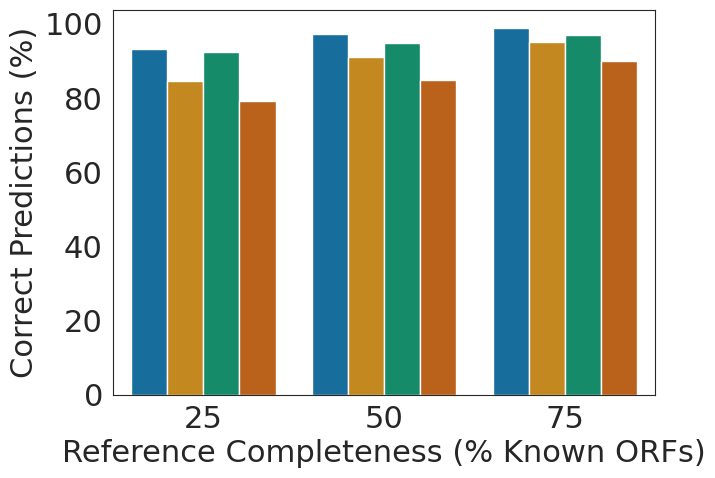

In [25]:
params = {'figure.figsize': (7,5),
          'legend.fontsize': 22,
          'axes.labelsize': 22,
          'axes.titlesize': 22,
          'xtick.labelsize': 22,
          'ytick.labelsize': 22}
pylab.rcParams.update(params)

sns.set_style("white")
ax = sns.barplot(x="perc", y="matching%", hue=" ", data=boot_df[boot_df["perc"]>1],ci=None,palette="colorblind")
plt.legend([],[], frameon=False)
plt.xlabel("Reference Completeness (% Known ORFs)")
plt.ylabel("Correct Predictions (%)")
plt.savefig(figdir+"bootstrap.correct.svg")

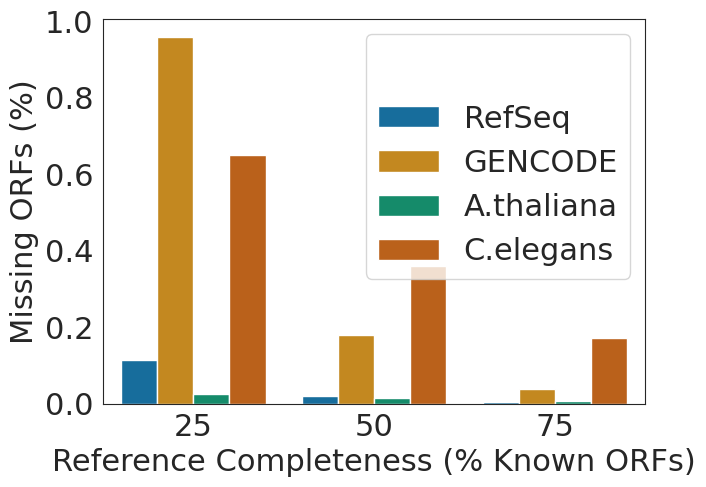

In [26]:
sns.set_style("white")
ax = sns.barplot(x="perc", y="missing%", hue=" ", data=boot_df[boot_df["perc"]>1],ci=None,palette="colorblind")
sns.move_legend(ax, "upper right")
plt.xlabel("Reference Completeness (% Known ORFs)")
plt.ylabel("Missing ORFs (%)")
plt.savefig(figdir+"bootstrap.missing.svg")